# Exploratory Data Analysis
https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies/notebook


In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from scipy.ndimage import imread
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
TRAIN_FOLDER = './data/train/'
INPUT_FOLDER = TRAIN_FOLDER + 'input/'
LABELS_FOLDER = TRAIN_FOLDER + 'labels/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(patients)

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552', '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1', '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e', '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed', '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf', '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21', '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426', '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339', '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776', '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe', '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a', '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd', '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e', '05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13', '0532c64c2fd0c4d3188cc751cdfd566b1cfba3d2693587

In [9]:
from skimage.color import rgb2gray

def load_input_image(patient):
    return rgb2gray(imread(INPUT_FOLDER + patient + '/images/' + os.listdir(INPUT_FOLDER + patient + '/images/')[0]))
    
def load_input_masks(patient):
    masks = os.listdir(INPUT_FOLDER + patient + '/masks/')
    return [imread(INPUT_FOLDER + patient + '/masks/' + mask) for mask in masks]


## EDA
Let's start by looking at some of the training images and a few of their respective masks

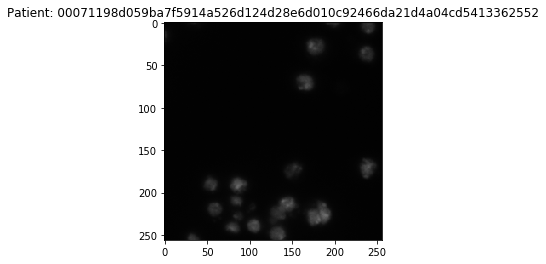

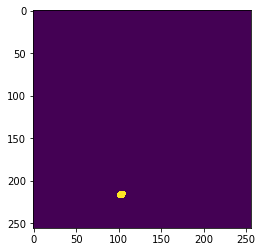

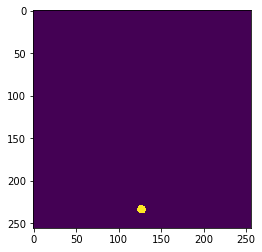

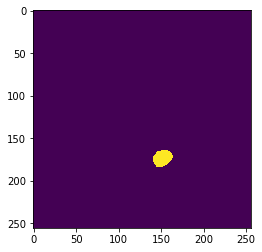

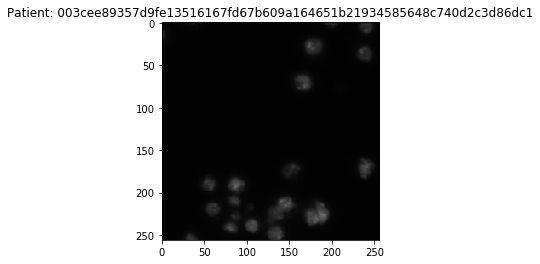

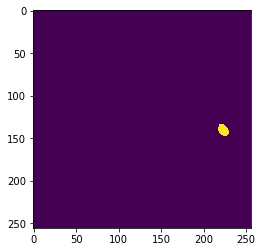

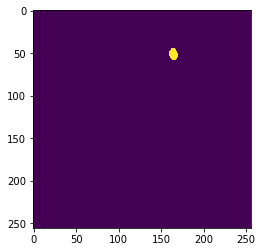

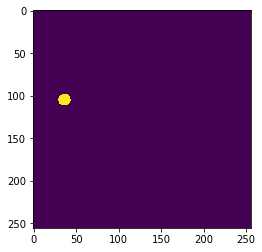

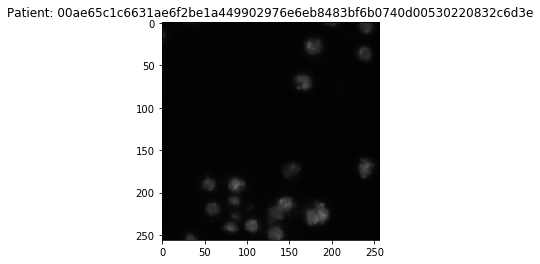

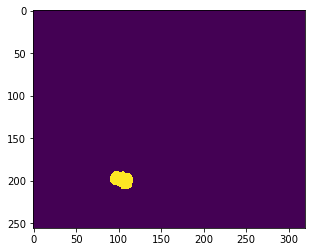

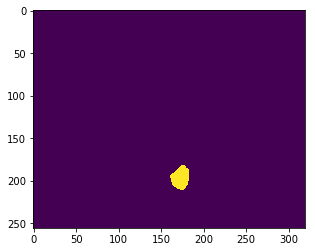

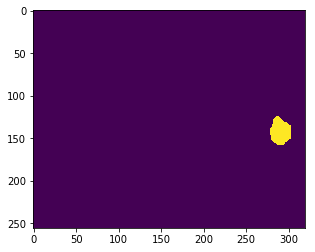

In [6]:
for patient in patients[:3]:
    masks = load_input_masks(patient)
    i = 1
    fig = plt.figure()
#     fig.add_subplot(1,len(masks),i)
    i+=1
    plt.title("Patient: {}".format(patient))
    plt.imshow(load_input_image(patients[0]))
    for mask in masks[:min(len(masks), 3)]:
#         fig.add_subplot(1,len(masks),i)
        plt.figure()
        i+=1
        plt.imshow(mask)

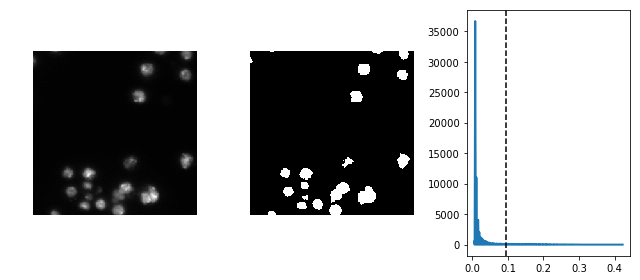

In [10]:
import matplotlib.pyplot as plt
try:
    from skimage import filters
except ImportError:
    from skimage import filter as filters
from skimage import exposure

img = load_input_image(patients[0])
val = filters.threshold_otsu(img)
segmented_img = img > val

hist, bins_center = exposure.histogram(img)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(img > val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()

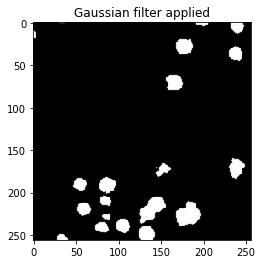

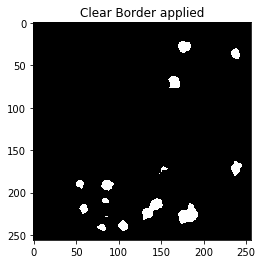

In [11]:
from skimage.segmentation import clear_border
from skimage.filters import gaussian

gauss_img = gaussian(segmented_img, sigma=.5)
plt.figure()
plt.title('Gaussian filter applied')
plt.imshow(gauss_img, cmap='gray')

clear_border_img = clear_border(gauss_img)
plt.figure()
plt.title('Clear Border applied')
plt.imshow(clear_border_img, cmap='gray')